<a href="https://colab.research.google.com/github/flaxoDS/CompletelyNew/blob/master/PneumoniaResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixg1999","key":"b1bc3432f37f4836d7e9449d9529ecdb"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/

In [4]:
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),        # ResNet default input
        transforms.RandomHorizontalFlip(),    # simple augmentation
        transforms.ToTensor(),
        transforms.Normalize(                 # ImageNet stats
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225],
        ),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225],
        ),
    ]),
}


FileNotFoundError: [Errno 2] No such file or directory: 'chest_xray/train'

In [7]:
import os

print("Folders in current directory:")
print(os.listdir())


Folders in current directory:
['.config', 'chest_xray', 'chest-xray-pneumonia.zip', 'sample_data']


In [8]:
print("Folders in chest_xray (if it exists):")
print(os.listdir("chest_xray"))


Folders in chest_xray (if it exists):
['chest_xray']


In [9]:
data_dir = "chest_xray/chest_xray"  # updated root path

train_ds = ImageFolder(f"{data_dir}/train", transform=data_transforms["train"])
val_ds   = ImageFolder(f"{data_dir}/val",   transform=data_transforms["val"])
test_ds  = ImageFolder(f"{data_dir}/test",  transform=data_transforms["val"])


In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)



In [11]:
train_ds.classes

['NORMAL', 'PNEUMONIA']

In [13]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [14]:
from torchvision import models
import torch.nn as nn
import torch

# Step 1: Load the pretrained model
model = models.resnet18(pretrained=True)

# Step 2: Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# ✅ Step 3: Get `in_features` BEFORE replacing model.fc
num_features = model.fc.in_features  # must be done while it's still Linear

# Step 4: Replace the classifier head
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(128, 2)
)

# Step 5: Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [15]:
print(model.fc)  # Shows the current layer


Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=2, bias=True)
)


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Device in use:", device)


Device in use: cuda


In [19]:
num_epochs = 5

for epoch in range(num_epochs):
    # — Training phase —
    model.train()
    train_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    # — Validation phase —
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    train_loss /= len(train_ds)
    val_loss   /= len(val_ds)
    val_acc     = correct / len(val_ds)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}  "
          f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2%}")
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)



Epoch 1/5 — Train Loss: 0.2179  Val Loss: 0.5269  Val Acc: 75.00%
Epoch 2/5 — Train Loss: 0.1401  Val Loss: 0.4533  Val Acc: 81.25%
Epoch 3/5 — Train Loss: 0.1508  Val Loss: 0.3430  Val Acc: 81.25%
Epoch 4/5 — Train Loss: 0.1208  Val Loss: 0.2308  Val Acc: 87.50%
Epoch 5/5 — Train Loss: 0.1289  Val Loss: 0.2148  Val Acc: 81.25%


In [20]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
print(f"Test Accuracy: {correct/total:.2%}")


Test Accuracy: 85.58%


In [ ]:
!nvidia-smi


In [ ]:
import torch
print("Device in use:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only 😢")


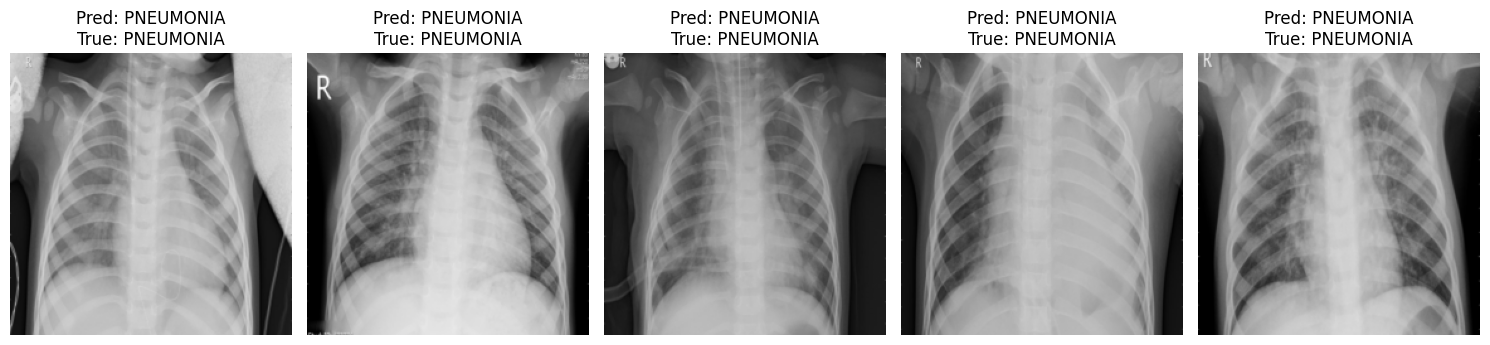

In [21]:
import matplotlib.pyplot as plt
import random
import torch

# Make sure the model is in eval mode
model.eval()

# Denormalization function for visualization
def imshow(img_tensor, ax, title=None):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.cpu() * std + mean  # De-normalize
    img = img.permute(1, 2, 0).clamp(0, 1)  # [C,H,W] → [H,W,C]
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title)

# Pick 5 random test samples
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
samples = random.sample(range(len(test_ds)), 5)

for i, idx in enumerate(samples):
    img, label = test_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()
    class_names = test_ds.classes
    true_label = class_names[label]
    predicted = class_names[pred]
    color = "green" if pred == label else "red"
    imshow(img, axs[i], title=f"Pred: {predicted}\nTrue: {true_label}")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Loss over Epochs')

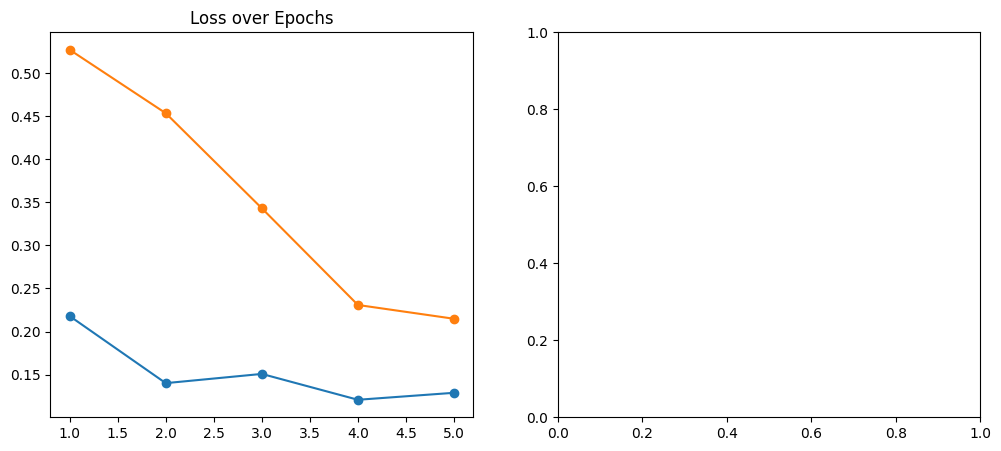

In [24]:
import matplotlib.pyplot as plt

# Replace these with your actual values if you tracked them dynamically
train_losses = [0.2179, 0.1401, 0.1508, 0.1208, 0.1289]
val_losses   = [0.5269, 0.4533, 0.3430, 0.2308, 0.2148]
val_accuracies = [0.75, 0.8125, 0.8125, 0.875, 0.8125]


epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax1.plot(epochs, train_losses, label='Train Loss', marker='o')
ax1.plot(epochs, val_losses, label='Val Loss', marker='o')
ax1.set_title('Loss over Epochs')
